In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

from imblearn.over_sampling import SMOTE

import pickle

In [2]:
df_train = pd.read_csv("df_train", low_memory = False);
df_test = pd.read_csv("df_test", low_memory = False);

In [3]:
df_train.head()

,proba,true_val,int_rate,amnt,total_pymnt,term,ZIP,ROI,Real_ROI,annualized_amnt
0,0.227251,1,0.0699,10400.0,6611.69,3.0,937.0,-0.071254,-1457.484111,3466.666667
1,0.419370,0,0.1239,15000.0,17392.37,5.0,235.0,-0.159232,450.579052,3000.000000
2,0.559138,1,0.1366,7650.0,2281.98,3.0,850.0,-0.247996,-2538.540767,2550.000000
3,0.563530,0,0.1366,9600.0,9973.43,3.0,77.0,-0.251017,122.896662,3200.000000
4,0.613782,0,0.1559,21425.0,25512.20,5.0,658.0,-0.278128,761.369757,4285.000000


In [4]:
df_test = df_test.sort_values(by=['ROI'])
df_train = df_train.sort_values(by=['ROI'])

In [5]:
df_test['Rank'] = np.arange(0,df_test.shape[0])
df_test['Rank'] = df_test['Rank']/df_test.shape[0]

df_train['Rank'] = np.arange(0,df_train.shape[0])
df_train['Rank'] = df_train['Rank']/df_train.shape[0]

df_test.head()

,proba,true_val,int_rate,amnt,total_pymnt,term,ZIP,ROI,Real_ROI,annualized_amnt,Rank
13778,0.835940,1,0.1318,28000,18865.780000,3.0,294,-0.439178,-3453.083641,9333.333333,0.000000
284695,0.835835,0,0.1333,33600,39519.895741,3.0,79,-0.438860,1867.571125,11200.000000,0.000003
103531,0.835118,1,0.1333,28000,26759.920000,3.0,600,-0.438369,-419.617104,9333.333333,0.000006
28685,0.832130,0,0.1318,30025,35631.759419,3.0,240,-0.436575,1763.333928,10008.333333,0.000009
226515,0.830394,0,0.1333,34200,39369.699897,3.0,939,-0.435135,1643.034655,11400.000000,0.000012


/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


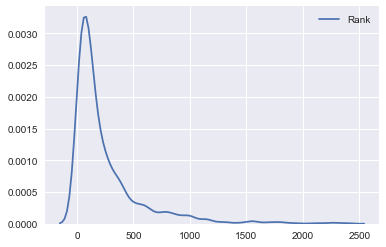

In [6]:
sns.kdeplot(df_train.groupby('ZIP').count().Rank)

In [7]:
df_train_residuals = df_train.groupby(by = 'ZIP').agg({
                            'ZIP' : ['count'],
                            'Rank' : np.mean
                                })

df_test_residuals = df_test.groupby(by = 'ZIP').agg({
                            'ZIP' : ['count'],
                            'Rank' : np.mean
                                })

In [8]:
zip_df = pd.read_csv("../data/2015_loan_data/pct_accepted_by_zip3_2015.csv", low_memory = False);

In [9]:
zip_df.dtypes

zip_code                      int64
pct_accepted                float64
num_loan_apps_considered    float64
dtype: object

In [10]:
zip_df.columns = ['ZIP'] + list(zip_df.columns[1:]);
zip_df.head()

,ZIP,pct_accepted,num_loan_apps_considered
0,7,0.022472,91.0
1,8,0.014706,69.0
2,10,0.090996,4544.0
3,11,0.059585,2045.0
4,12,0.077759,1289.0


In [11]:
mean_accept_rate = np.sum(zip_df.pct_accepted*zip_df.num_loan_apps_considered)/np.sum(zip_df.num_loan_apps_considered)
print(mean_accept_rate)

0.0879457740068084


In [12]:
df_train.ZIP = df_train.ZIP.astype(int)
df_test.ZIP = df_test.ZIP.astype(int)

In [13]:
pct_acc_mean = zip_df.pct_accepted.mean();
pct_acc_std = zip_df.pct_accepted.std();

/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


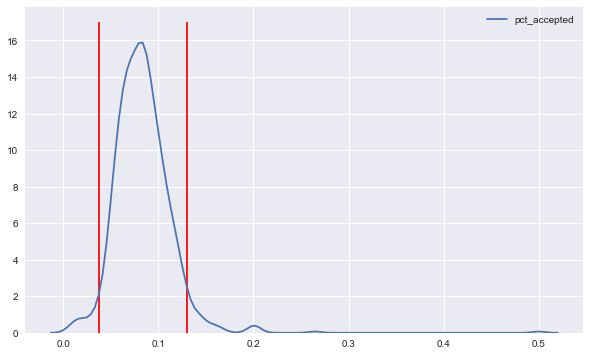

In [14]:
fig = plt.figure(figsize=(10,6));
ax = plt.subplot(1,1,1);
std_mult = 1.5;
ax.vlines(x=[pct_acc_mean + std_mult*pct_acc_std, pct_acc_mean - std_mult*pct_acc_std], ymin=0, ymax=17, colors='r')

sns.kdeplot(zip_df.pct_accepted, ax = ax)
plt.show()

In [15]:
merged_df_train = pd.merge(df_train, zip_df, on=['ZIP'])
merged_df_train.head()

,proba,true_val,int_rate,amnt,total_pymnt,term,ZIP,ROI,Real_ROI,annualized_amnt,Rank,pct_accepted,num_loan_apps_considered
0,0.840994,1,0.1786,15750.0,9997.280000,5.0,544,-0.435188,-1368.611528,3150.0,0.000000,0.083717,2356.0
1,0.841384,1,0.2020,19475.0,17658.080000,5.0,544,-0.431761,-377.757227,3895.0,0.000206,0.083717,2356.0
2,0.810332,1,0.1892,18900.0,13368.400000,5.0,544,-0.410800,-1264.599389,3780.0,0.011484,0.083717,2356.0
3,0.798349,0,0.2450,11725.0,13044.160000,5.0,544,-0.390675,252.702020,2345.0,0.025047,0.083717,2356.0
4,0.775508,0,0.1659,15000.0,15652.215904,5.0,544,-0.390245,128.231902,3000.0,0.025477,0.083717,2356.0


In [16]:
def clipped_pct(x):
    if x > pct_acc_mean + std_mult*pct_acc_std:
        return pct_acc_mean + std_mult*pct_acc_std
    elif x < pct_acc_mean - std_mult*pct_acc_std:
        return pct_acc_mean - std_mult*pct_acc_std
    else:
        return x

In [17]:
merged_df_train['clipped_pct'] = merged_df_train.pct_accepted.map(clipped_pct)
merged_df_train['adjustment_factor'] = merged_df_train['clipped_pct'].mean()/merged_df_train['clipped_pct']

In [18]:
merged_df_train.describe()

,proba,true_val,int_rate,amnt,total_pymnt,term,ZIP,ROI,Real_ROI,annualized_amnt,Rank,pct_accepted,num_loan_apps_considered,clipped_pct,adjustment_factor
count,218391.000000,218391.000000,218391.000000,218391.000000,218391.000000,218391.000000,218391.000000,218391.000000,218391.000000,218391.000000,218391.000000,218390.000000,218390.000000,218390.000000,218390.000000
mean,0.413772,0.189834,0.136056,14479.475688,15662.411555,3.511908,512.266884,-0.155458,202.940549,4144.529620,0.499998,0.092502,8512.483076,0.092155,1.052561
std,0.195257,0.392170,0.043296,8388.687985,10301.435810,0.872794,312.068044,0.114660,1494.524286,2378.949685,0.288676,0.020611,6796.649336,0.019763,0.256021
min,0.025381,0.000000,0.060000,1000.000000,0.000000,3.000000,7.000000,-0.435188,-30375.000000,200.000000,0.000000,0.007143,3.000000,0.037509,0.709678
25%,0.252650,0.000000,0.104900,8000.000000,7794.837844,3.000000,231.000000,-0.240341,166.179757,2400.000000,0.249999,0.078252,3379.000000,0.078252,0.864310
50%,0.397412,0.000000,0.133500,12250.000000,13142.470000,3.000000,474.000000,-0.137213,440.856378,3500.000000,0.499998,0.091285,6601.000000,0.091285,1.009524
75%,0.563332,0.000000,0.162900,20000.000000,21341.590000,5.000000,802.000000,-0.061408,815.080346,5333.333333,0.749997,0.106622,12127.000000,0.106622,1.177667
max,0.844520,1.000000,0.260600,35000.000000,62070.704532,5.000000,999.000000,0.056478,4697.198103,11666.666667,0.999995,0.500000,31011.000000,0.129854,2.456851


In [19]:
def adjust_ROI(df):
    df['adjusted_ROI'] = 0
    mean_adj_factor = df.adjustment_factor.mean()
    for i in range(len(df)):
        adjustment = abs(df.iloc[i].ROI)*(df.iloc[i].adjustment_factor - mean_adj_factor + 1)
        df.adjusted_ROI = df.ROI + adjustment
    return df

In [128]:
mean_adj_factor = merged_df_train.adjustment_factor.mean();
alpha = 0.1

def adjust_ROI(x):
    adjustment = abs(x.ROI)*alpha*(x.adjustment_factor - mean_adj_factor);
    return x.ROI + adjustment;

In [129]:
merged_df_train['adjusted_ROI'] = merged_df_train.apply(adjust_ROI, axis=1);

In [143]:
train_final = merged_df_train.sort_values(by=['adjusted_ROI'])

In [133]:
train_final['adjusted_Rank'] = np.arange(0,train_final.shape[0])
train_final['adjusted_Rank'] = train_final['adjusted_Rank']/train_final.shape[0]

In [134]:
train_final.head()

,proba,true_val,int_rate,amnt,total_pymnt,term,ZIP,ROI,Real_ROI,annualized_amnt,Rank,pct_accepted,num_loan_apps_considered,clipped_pct,adjustment_factor,adjusted_ROI,adjusted_Rank
16171,0.836941,1,0.1786,16000.0,16072.310000,5.0,941,-0.432230,14.435927,3200.0,0.000114,0.141962,8205.0,0.129854,0.709678,-0.447051,0.000000
21230,0.836353,0,0.1786,17700.0,23540.009770,5.0,852,-0.431801,1038.720818,3540.0,0.000165,0.129393,13337.0,0.129393,0.712208,-0.446497,0.000005
38066,0.841087,1,0.2020,15550.0,11585.010000,5.0,222,-0.431538,-888.999880,3110.0,0.000298,0.158537,1710.0,0.129854,0.709678,-0.446335,0.000009
22930,0.841420,1,0.2020,14300.0,6635.940000,5.0,971,-0.431789,-2035.514895,2860.0,0.000174,0.126525,2493.0,0.126525,0.728351,-0.445788,0.000014
45310,0.842681,0,0.2118,16475.0,26636.155874,5.0,220,-0.431197,1661.548774,3295.0,0.000394,0.127995,4001.0,0.127995,0.719984,-0.445537,0.000018


In [135]:
train_final_data = train_final.groupby('ZIP').agg({
                'ZIP' : {'Count' : 'count'},
                'adjusted_Rank' : np.mean,
                'Rank' : np.mean
            })

/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4658: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [136]:
ranked_df = pd.DataFrame(train_final_data.to_records())

In [137]:
ranked_df.columns = ['ZIP', 'Count', 'adj_rank_mean', 'rank_mean']

In [138]:
ranked_df['Predicted_mean'] = 0.5

In [139]:
ranked_df.head()

,ZIP,Count,adj_rank_mean,rank_mean,Predicted_mean
0,7,2,0.207330,0.133025,0.5
1,8,1,0.886442,0.873223,0.5
2,10,352,0.498898,0.500496,0.5
3,11,109,0.420354,0.401535,0.5
4,12,85,0.543531,0.539535,0.5


In [140]:
from sklearn.metrics import r2_score

In [141]:
r2_score((ranked_df.adj_rank_mean*ranked_df.Count), (ranked_df.Predicted_mean*ranked_df.Count))

0.9965823808691432

In [142]:
r2_score((ranked_df.rank_mean*ranked_df.Count), (ranked_df.Predicted_mean*ranked_df.Count))

0.9958349672793182